In [1]:
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.model_selection import train_test_split

import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


In [3]:
DIR = './histopathologic-cancer-detection'

df_labels = pd.read_csv(f'{DIR}/train_labels.csv')
df_samples = pd.read_csv(f'{DIR}/sample_submission.csv')

df_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
train_dir = f"{DIR}/train/"
test_dir = f"{DIR}/test"

print(f"Number of training images: {len(os.listdir(train_dir))}")
print(f"Number of test images: {len(os.listdir(test_dir))}")

Number of training images: 220025
Number of test images: 57458


In [6]:
img_train = os.listdir(train_dir)
img_test = os.listdir(test_dir)

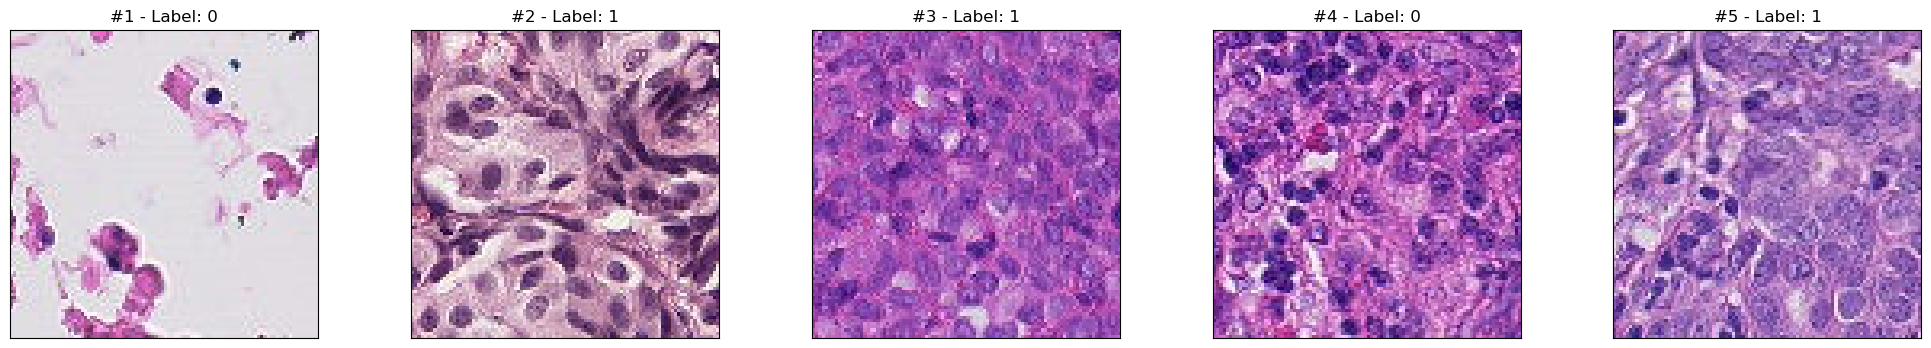

In [7]:
fig = plt.figure(figsize=(25, 4))

for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    im = Image.open(train_dir + img_train[i])
    plt.imshow(im)
    label = df_labels.loc[df_labels['id'] == img_train[i].split('.')[0], 'label'].values[0]
    ax.set_title(f'#{i+1} - Label: {label}')

label
0    130908
1     89117
Name: count, dtype: int64


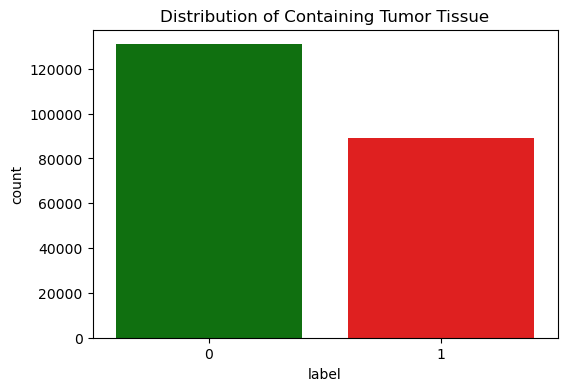

In [8]:
print(df_labels['label'].value_counts())
plt.figure(figsize=(6, 4))
sns.countplot(x='label', hue='label', data=df_labels, palette={1: 'red', 0: 'green'}, legend=False)
plt.title('Distribution of Containing Tumor Tissue')
plt.show()

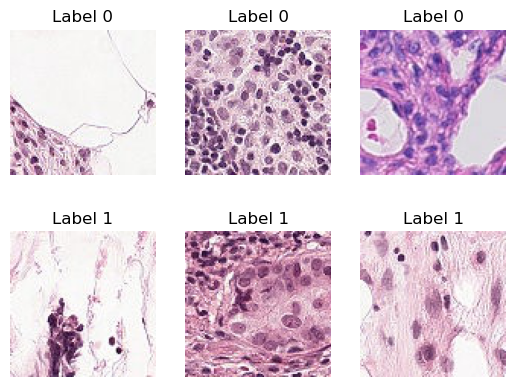

In [9]:
df_labels["path"] = df_labels["id"].apply(lambda x: os.path.join("./histopathologic-cancer-detection/train", str(x) + ".tif"))

images_with_label_0 = df_labels[df_labels["label"] == 0]
images_with_label_1 = df_labels[df_labels["label"] == 1]

for i in range(3):
    image = plt.imread(images_with_label_0["path"].iloc[i])

    plt.subplot(2, 3, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Label 0")

for i in range(3):
    image = plt.imread(images_with_label_1["path"].iloc[i])

    plt.subplot(2, 3, 3 + i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Label 1")


plt.show()

In [10]:
df_labels["path"] = df_labels["id"].apply(lambda x: os.path.join("./histopathologic-cancer-detection/train", str(x) + ".tif"))

In [11]:
x_train, x_val, y_train, y_val = train_test_split(df_labels['path'], df_labels['label'], test_size=0.2, random_state=42, stratify=df_labels['label'])

In [12]:
print(x_train.shape, x_val.shape)

(176020,) (44005,)


In [13]:
import shutil
train_dir = "train_data"
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)
os.makedirs(os.path.join(train_dir, "0"))
os.makedirs(os.path.join(train_dir, "1"))
for file_path, label in zip(x_train, y_train):
    name = file_path.split("/")[-1]
    if label == "0":
        shutil.copy2(file_path, os.path.join(train_dir, "0", name))
    else:
        shutil.copy2(file_path, os.path.join(train_dir, "1", name))

val_dir = "val_data"
if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)
os.makedirs(os.path.join(val_dir, "0"))
os.makedirs(os.path.join(val_dir, "1"))

for file_path, label in zip(x_val, y_val):
    name = file_path.split("/")[-1]
    if label == "0":
        shutil.copy2(file_path, os.path.join(val_dir, "0", name))
    else:
        shutil.copy2(file_path, os.path.join(val_dir, "1", name))

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    shuffle=True,
    seed=42
)
val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False,
    seed=42
)

Found 176020 images belonging to 2 classes.
Found 44005 images belonging to 2 classes.


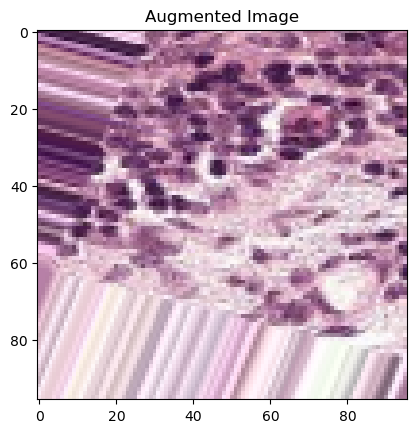

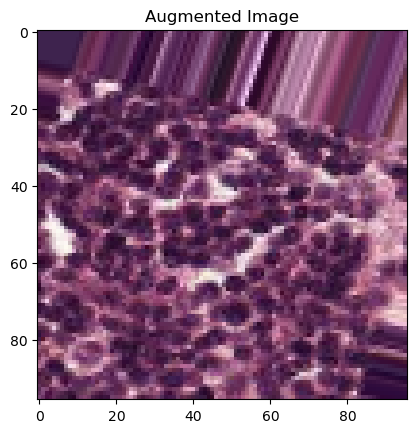

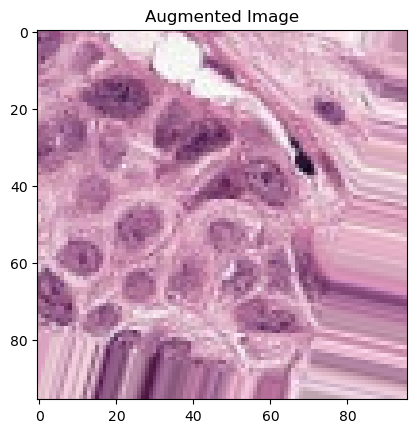

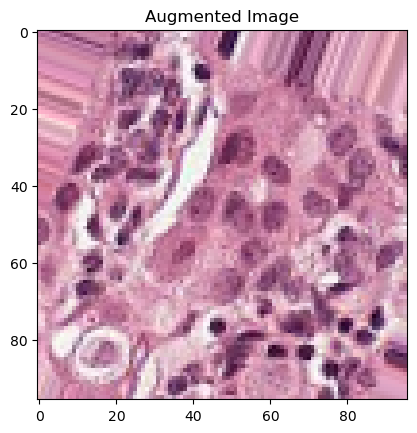

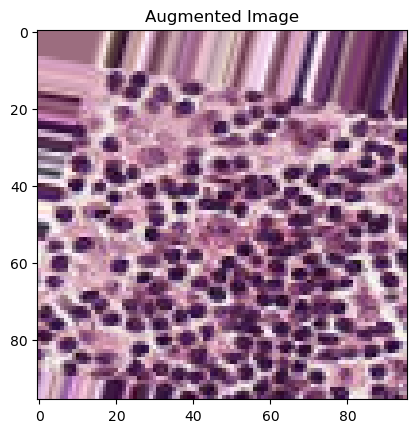

In [14]:
# Visualize Augmented Images
# Define a function to visualize how the augmented images look like
def show_augmented_images(data_gen):
    # We'll display 5 augmented images as an example
    for i in range(5):
        img, label = next(data_gen)
        plt.imshow(img[0])
        plt.title('Augmented Image')
        plt.show()

# Call the function to see augmented images from the training generator
show_augmented_images(train_generator)

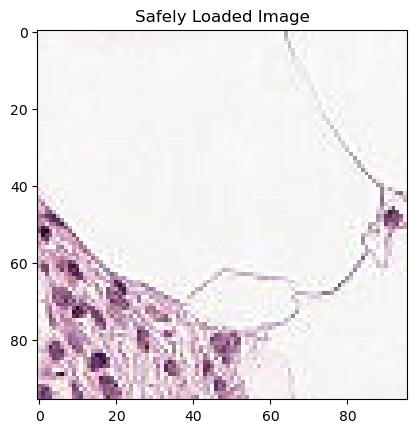

In [16]:
def safe_image_load(path):
    try:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        return None

# Test the safe image loading function with a sample image path
sample_img = safe_image_load(x_train[0])
if sample_img is not None:
    plt.imshow(sample_img)
    plt.title('Safely Loaded Image')
    plt.show()

# State-of-the-art Model

In [17]:
from keras.applications import InceptionV3
from keras import Model
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

In [18]:
incept_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

for layer in incept_model.layers:
    layer.trainable = False

last_layer = incept_model.get_layer('mixed2')

base_model = Model(inputs=incept_model.input, outputs=last_layer.output)

2024-04-13 14:39:28.792866: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-13 14:39:28.792891: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-13 14:39:28.792895: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-13 14:39:28.792912: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-13 14:39:28.792923: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
x = Flatten()(incept_model.output)

x = Dense(64, activation='relu')(x)

x = Dropout(0.2)(x)

x = Dense(1, activation='sigmoid')(x)

new_model = Model(incept_model.input, x)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 47, 47,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 47, 47,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 47, 47,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 45, 45,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 45, 45,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 22, 22,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 22, 22,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 22,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 22, 22,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 20, 20,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 20,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 20, 20,    │          0 │ batch_normalizat

 Total params: 21,933,985 (83.67 MB)

 Trainable params: 131,201 (512.50 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [21]:
new_model.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[keras.metrics.BinaryAccuracy()]
)

In [22]:
BATCH_SIZE = 32
EPOCHS = 1

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

steps_per_epoch = len(train_generator) 
validation_steps = len(val_generator)

history = new_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1,
    callbacks=[es]
)

2024-04-13 14:39:31.678166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/opt/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 417s 75ms/step - binary_accuracy: 0.9972 - loss: 0.0075 - val_binary_accuracy: 1.0000 - val_loss: 3.7075e-06


In [23]:
from sklearn.metrics import f1_score,recall_score, precision_score, accuracy_score

In [25]:
samples_val = len(os.listdir(os.path.join(val_dir, '1'))) + len(os.listdir(os.path.join(val_dir, '0')))
val_generator_for_pred = val_datagen.flow_from_directory(
    directory=val_dir, 
    batch_size=1, 
    class_mode='binary',
    target_size=(96,96),
    shuffle=False
)

Found 44005 images belonging to 2 classes.


In [26]:
val_predictions = new_model.predict(val_generator_for_pred, steps=samples_val, verbose=1)

44005/44005 ━━━━━━━━━━━━━━━━━━━━ 2057s 47ms/step


In [27]:
val_labels = val_generator.classes
binary_val_predictions = (val_predictions > 0.5).astype(int)

In [28]:
recall = recall_score(val_labels, binary_val_predictions)
precision = precision_score(val_labels, binary_val_predictions)
F1 = f1_score(val_labels, binary_val_predictions)
acc= accuracy_score(val_labels, binary_val_predictions)

print("Recall on validation set:", recall)
print("Precision on validation set:", precision)
print("F1 score on validation set:", F1)
print("Accuracy score on validation set:", acc)

Recall on validation set: 1.0
Precision on validation set: 1.0
F1 score on validation set: 1.0
Accuracy score on validation set: 1.0


In [31]:
df_samples["path"] = df_samples["id"].apply(lambda x: os.path.join("./histopathologic-cancer-detection/test", str(x) + ".tif"))
x_test, y_test = df_samples['path'], df_samples['label']
test_dir = "test_data"
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)
os.makedirs(os.path.join(test_dir, "0"))
os.makedirs(os.path.join(test_dir, "1"))

for file_path, label in zip(x_test, y_test):
    name = file_path.split("/")[-1]
    if label == "0":
        shutil.copy2(file_path, os.path.join(test_dir, "0", name))
    else:
        shutil.copy2(file_path, os.path.join(test_dir, "1", name))

In [32]:
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    directory=test_dir, 
    batch_size=1, 
    class_mode='binary',
    target_size=(96,96),
    shuffle=False
)

Found 57458 images belonging to 2 classes.


In [34]:
samples_test = len(os.listdir(os.path.join(test_dir, '1'))) + len(os.listdir(os.path.join(test_dir, '0')))
test_predictions = new_model.predict(test_generator, steps=samples_test, verbose=1)

test_labels = test_generator.classes

57458/57458 ━━━━━━━━━━━━━━━━━━━━ 2538s 44ms/step


array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [35]:
binary_test_predictions = (test_predictions > 0.5).astype(int)

recall = recall_score(test_labels, binary_test_predictions)
precision = precision_score(test_labels, binary_test_predictions)
F1 = f1_score(test_labels, binary_test_predictions)
acc= accuracy_score(test_labels, binary_test_predictions)

print("Recall on testing set:", recall)
print("Precision on testing set:", precision)
print("F1 score on testing set:", F1)
print("Accuracy score on testing set:", acc)

# cm = confusion_matrix(test_labels, binary_test_predictions)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-cancer', 'Cancer'])
# disp.plot(cmap='Blues', values_format='d')
# plt.show()

Recall on testing set: 1.0
Precision on testing set: 1.0
F1 score on testing set: 1.0
Accuracy score on testing set: 1.0
